In [19]:
#EE224 Pset 5
#Author: Kapil Dheeriya
#May 12, 2023
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as la
import math
from mpl_toolkits.axes_grid1 import AxesGrid
pi = np.pi

Problem 1: NMR Spectroscopy with Floquet Hamiltonian Engineering

In [3]:
#import pauli matrix code from PSet 1
pauli = np.array((((0, 1), (1, 0)), ((0, -1j), (1j, 0)), ((1, 0), (0, -1))))
I2 = np.eye(2)
a = np.zeros((2**5,2**5))

#generate list of length 5 for pauli 1,2, or 3 matrices for the qubit in the nth position of the list.
def paulilist(n: int):
    s=[]
    for i in range(1,6):
        mat = pauli[n-1] if i == 1 else I2
        for j in range(1,5):
            if i==j+1:
                mat = np.kron(mat, pauli[n-1])
            else: 
                mat = np.kron(mat, I2)
        s.append(mat)
    return s

#Plot code
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

#Lists of pauli matrices for each qubit
px = paulilist(1)
py = paulilist(2)
pz = paulilist(3)

Part a

In [127]:
shifts = (2*np.pi)*np.array([0.6, -1.4, 1.7, -2.9, 3.3])
#Generate non interacting hamiltonian
Hni = np.zeros((32,32))
for i in range(0,5):
    Hni = np.add(Hni, (1/2)*shifts[i]*pz[i])
Szmean = (1/5)*sum(pz)

#Generate state after first pi/2 pulse
equalSup = (1/np.sqrt(2))*np.array([1,1])
psi0 = np.kron(equalSup, equalSup)
for i in range(0,3):
    psi0 = np.kron(psi0, equalSup)

#Free evolution function
def evolve(psi, H, t):
    return la.expm(-1j*H*t)@psi

def pi2x(psi):
    return la.expm(-1j*(pi/2)*(1/2)*sum(px)) @ psi

def pi2xneg(psi):
    return la.expm(1j*(pi/2)*(1/2)*sum(px)) @ psi

def pi2y(psi):
    return la.expm(-1j*(pi/2)*(1/2)*sum(py)) @ psi

def pi2yneg(psi):
    return la.expm(1j*(pi/2)*(1/2)*sum(py)) @ psi

def expectation(operator, psi):
    return np.vdot(psi, operator@psi)

Numerical value of Pz at t = 0 ms:   (-1.3877787807814457e-17+0j)
Analytical value of Pz at t = 0 ms:   0.0
Numerical value of Pz at t = 100 ms:   (-5.449807272128737e-14+0j)
Analytical value of Pz at t = 100 ms:   -3.7632043729010645e-14


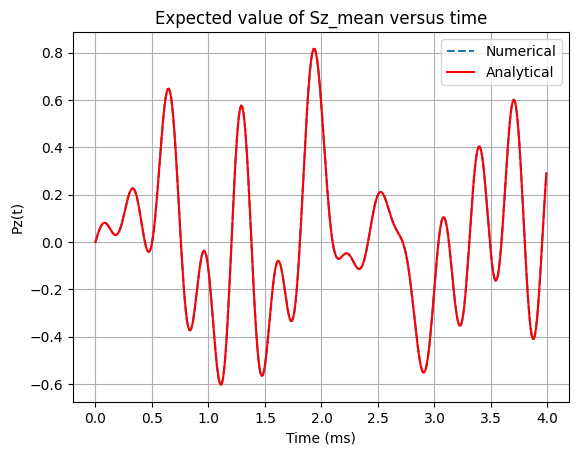

In [165]:
tmax = 100 #milliseconds
dt = 0.01 #ms
time = np.linspace(0,tmax, 1+round(tmax/dt))
Pz = []
for t in time:
    psi = evolve(psi0, Hni, t)
    psi = pi2x(psi)
    Pz.append(expectation(Szmean, psi))

#Numerically compute the analytical value of Pz
def pzanalytical(shifts, t):
    Pzanalytical = 0
    for delta in shifts:
        Pzanalytical += 0.2*np.sin(delta*t)
    return Pzanalytical

Pzanal = []
for t in time:
    Pzanal.append(pzanalytical(shifts, t))

#Print numerical/analytical value of Pz at t = 0 (should be zero)
print(f'Numerical value of Pz at t = 0 ms:   {Pz[0]}')
print(f'Analytical value of Pz at t = 0 ms:   {Pzanal[0]}')
#Print numerical/analytical value of Pz at t = 100 ms (last element in list)
print(f'Numerical value of Pz at t = 100 ms:   {Pz[-1]}')
print(f'Analytical value of Pz at t = 100 ms:   {Pzanal[-1]}')

fig, ax  = plt.subplots()
ax.plot(time[:400], np.real(Pz)[:400],label = 'Numerical', linestyle='dashed')
ax.plot(time[:400], Pzanal[:400], label = 'Analytical', color='red')
ax.set(xlabel='Time (ms)', ylabel='Pz(t)',
       title='Expected value of Sz_mean versus time')
ax.grid()
ax.legend()

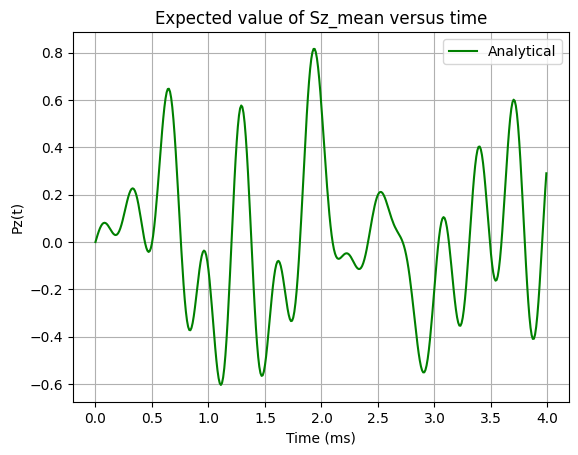

In [166]:
fig, ax  = plt.subplots()
ax.plot(time[:400], Pzanal[:400], label = 'Analytical', color='green')
ax.set(xlabel='Time (ms)', ylabel='Pz(t)',
       title='Expected value of Sz_mean versus time')
ax.grid()
ax.legend()

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


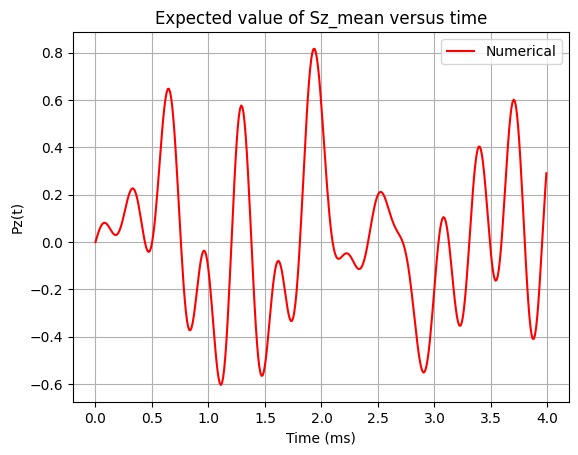

In [168]:
fig, ax  = plt.subplots()
ax.plot(time[:400], Pz[:400], label = 'Numerical', color='red')
ax.set(xlabel='Time (ms)', ylabel='Pz(t)',
       title='Expected value of Sz_mean versus time')
ax.grid()
ax.legend()

Indeed, we see that from the graph that Pz is bounded between -1 and +1, and the analytical and numerical values of Pz match up on the graphs.

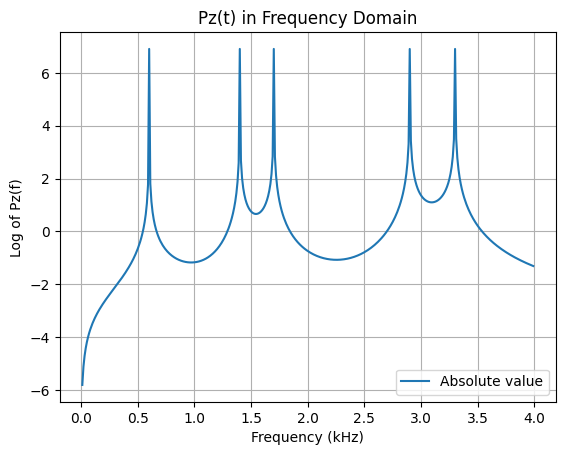

In [167]:
#Numerically obtain Fourier spectrum of Pz(t)
PzSpectrum = scipy.fft.fft(Pz)
fig, ax  = plt.subplots()
ax.plot(time[1:400], (np.log(np.abs(PzSpectrum[1:400]))), label = 'Absolute value')
ax.set(xlabel='Frequency (kHz)', ylabel='Log of Pz(f)',
       title='Pz(t) in Frequency Domain')
ax.grid()
ax.legend()

We clearly see the five chemical shifts as the peaks in the fourier spectrum. Their position in frequency space exactly matches up with the given values of (∆1, ∆2, ∆3, ∆4, ∆5) = 2π × (+0.6, −1.4, +1.7, −2.9, +3.3) kHz. I have ommitted DC noise (Pz[0]) to make a cleaner graph.

Extra credit: we can get information about the sign of the chemical shifts by examaning the real part of Pz in the frequency domain. Clearly the positive valued peaks are the positive valued chemical shifts, and the negative valued peaks are the negative valued chemical shifts:

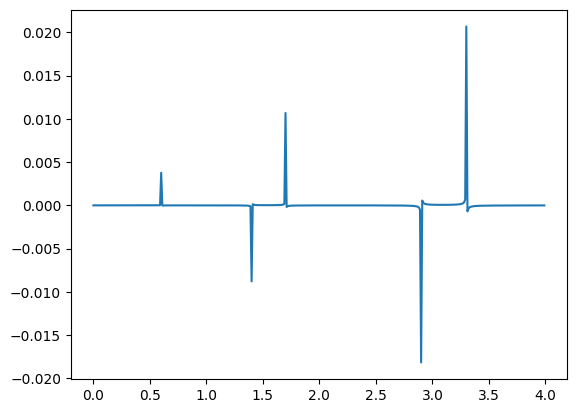

In [93]:
plt.plot(time[:400], (2/len(time))*np.real(PzSpectrum[:400]))

Part B

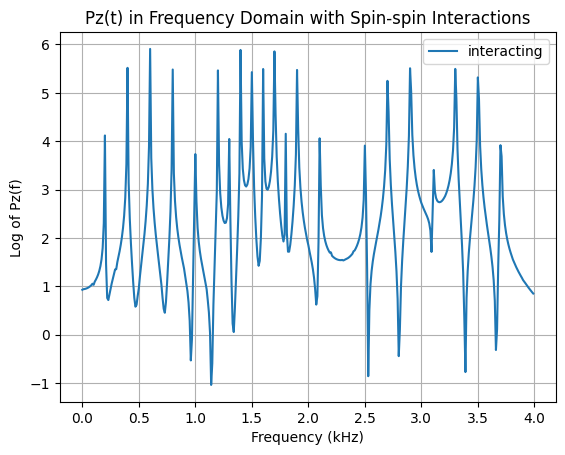

In [159]:
#Generate interaction Hamiltonian
J = 2*pi*0.1
Hint = Hni
for i in range(0,4):
    for j in range(i+1,5):
        Hint = np.add(Hint, (J/4)*(px[i]@px[j] + py[i]@py[j] -2*pz[i]@pz[j]))
#Generate Pz(t) with interaction term in Hamiltonian
Pzint = []
for t in time:
    psi = evolve(psi0, Hint, t)
    psi = pi2x(psi)
    Pzint.append(expectation(Szmean, psi))

PzSpectrumInt = scipy.fft.fft(Pzint)
fig, ax  = plt.subplots()
ax.plot(time[:400], (np.log(np.abs(PzSpectrumInt[:400]))), label = 'interacting')
ax.set(xlabel='Frequency (kHz)', ylabel='Log of Pz(f)',
       title='Pz(t) in Frequency Domain with Spin-spin Interactions')
ax.grid()
ax.legend()

Note that both the interacting and non interacting Hamiltonians have peaks at the chemical shift frequencies, but in the interacting Hamiltonian, we see that each peak has 4 additional side bands, different from the non-interacting Hamiltonian. These sidebands correspond to the interactions between a given qubit with a chemical shift and the four other qubits with different chemical shifts.

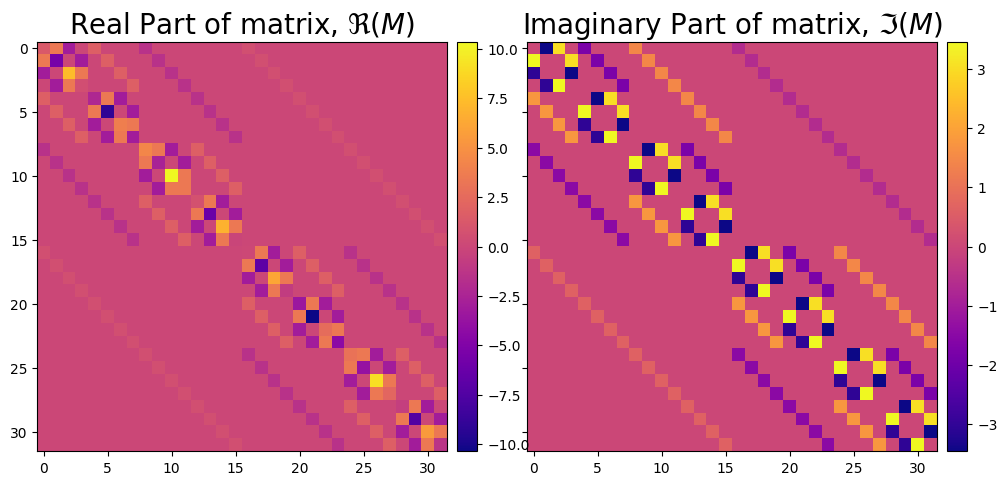

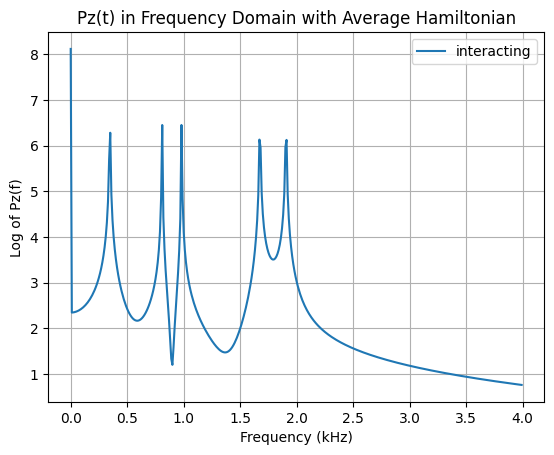

In [170]:
Havg = np.zeros((32,32))
for i in range(0,5):
    Havg = np.add(Havg, (1/3)*shifts[i]*(1/2)*(px[i]+py[i]+pz[i]))
heatmap2d(Havg)

#Generate Pz(t) with Floquet Hamiltonian
Pzfloq = []
for t in time:
    psi = evolve(psi0, Havg, t)
    psi = pi2x(psi)
    Pzfloq.append(expectation(Szmean, psi))


PzSpectrumFloq = scipy.fft.fft(Pzfloq)
fig, ax  = plt.subplots()
ax.plot(time[:400], (np.log(np.abs(PzSpectrumFloq[:400]))), label = 'interacting')
ax.set(xlabel='Frequency (kHz)', ylabel='Log of Pz(f)',
       title='Pz(t) in Frequency Domain with Average Hamiltonian')
ax.grid()
ax.legend()

The resonance frequencies are apparent from the fourier spectrum, with the peaks corresponding to each chemical shift. Note that resonance frequencies are the chemical shift frequencies scaled down by a factor of sqrt(3), consistent with our prediction in aii. This is because the average Hamiltonian represents a rotation of the state vector of each qubit around the axis (1,1,1) instead of around the z axis as in our original non interacting Hamiltonian. Therefore we get a restriction in the possible values that Pz(t) can take on because the projection of the state vector onto the z axis at the end of the sequence is shifted up and thus Pz has a smaller range centered on ~0.4, a DC signal which we can see on the spectrum.

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


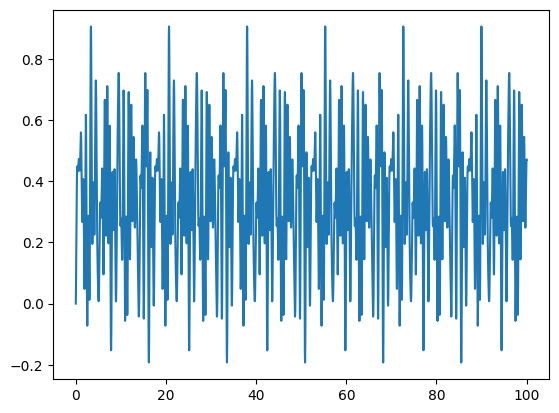

In [171]:
plt.plot(time, Pzfloq)

Part C

In [151]:

pi2xmat = la.expm(-1j*(pi/2)*(1/2)*sum(px))
pi2xnegmat = la.expm(1j*(pi/2)*(1/2)*sum(px))
pi2ymat = la.expm(-1j*(pi/2)*(1/2)*sum(py))
pi2ynegmat = la.expm(1j*(pi/2)*(1/2)*sum(py))

#full WAHUHA sequence operator with full Hamiltonian
def wahuha2(Hint, t, T):
    M = int(t/T)
    U = la.expm(-1j*Hint*(T/6))
    U2 = la.expm(-1j*Hint*(T/3))
    operator = U@pi2xnegmat@U@pi2ymat@U2@pi2ynegmat@U@pi2xmat@U
    operator = pi2xmat@np.linalg.matrix_power(operator, M)
    return operator

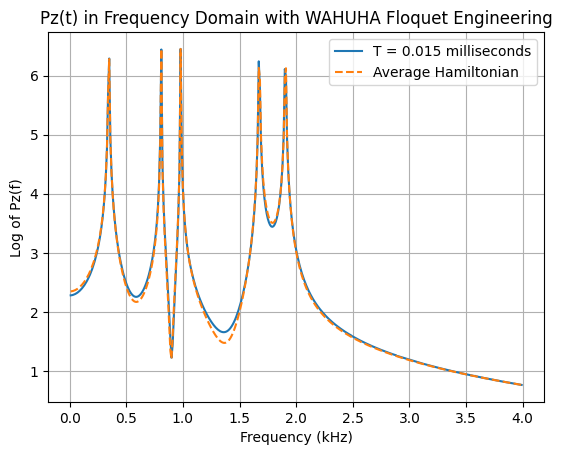

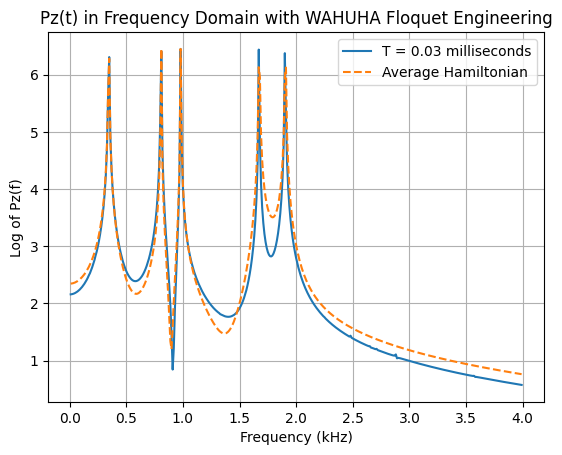

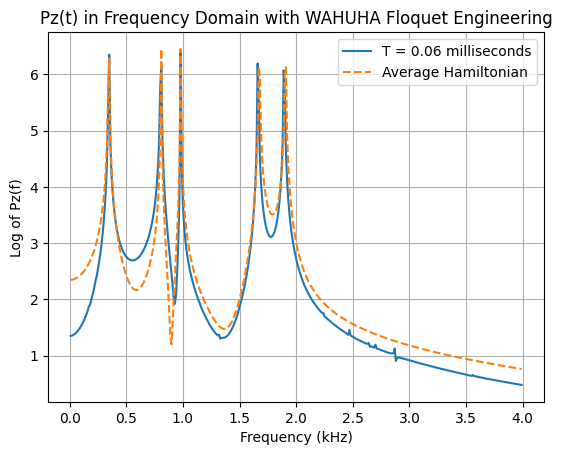

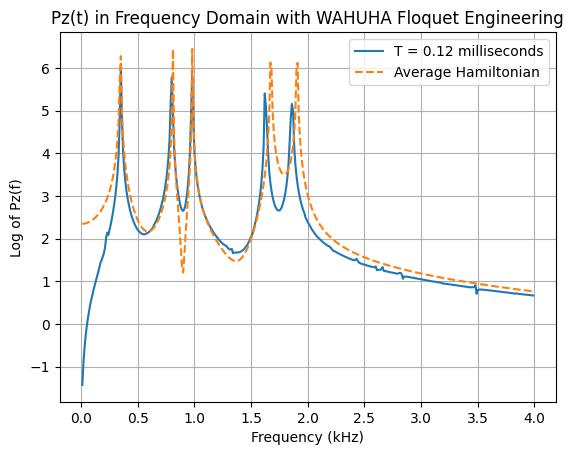

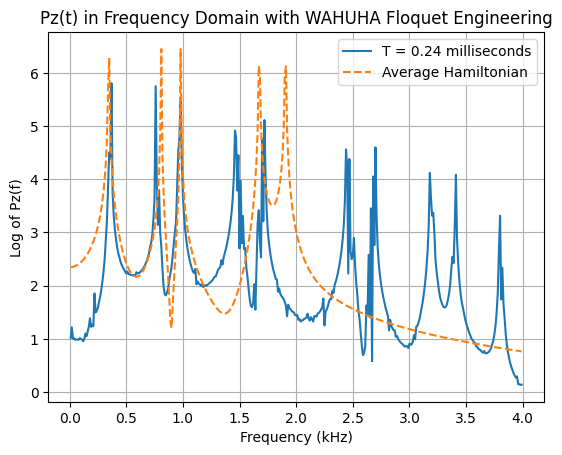

In [160]:
def plotfft(data, time, T):
    fig, ax  = plt.subplots()
    ax.plot(time[1:400], np.log((np.abs(data[1:400]))), label = f'T = {T} milliseconds')
    ax.plot(time[1:400], (np.log(np.abs(PzSpectrumFloq[1:400]))), label = 'Average Hamiltonian', linestyle = 'dashed')
    ax.set(xlabel='Frequency (kHz)', ylabel='Log of Pz(f)',
        title='Pz(t) in Frequency Domain with WAHUHA Floquet Engineering')
    ax.grid()
    ax.legend()

timeset = [0.015,0.030,0.060,0.120,0.240]
for T in timeset:
    Mmax = round(100/T)
    PzWAHUHA = []
    for t in time:
        state =  wahuha2(Hint, t, T)@psi0
        PzWAHUHA.append(expectation(Szmean, state))
    PzWAHUHAspectrum = scipy.fft.fft(PzWAHUHA)
    plotfft(PzWAHUHAspectrum, time, T)

We can clearly see that breakdown in the frequency of the chemical shifts occurs for the T=0.12 ms and T=0.24 ms cases, so the regime in which our average Hamiltonian theory becomes valid is between 0.06 and .12 milliseconds. Therefore 0  < delta5*T/2pi < ~3.3x0.1 is the valid regime. This is the regime that delta5*T/2pi is small compared to the largest local energy scale.

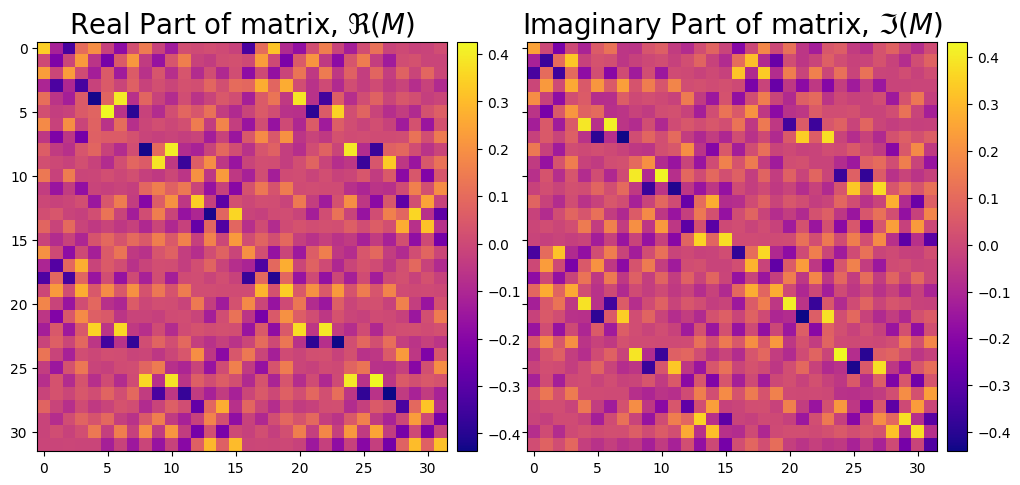

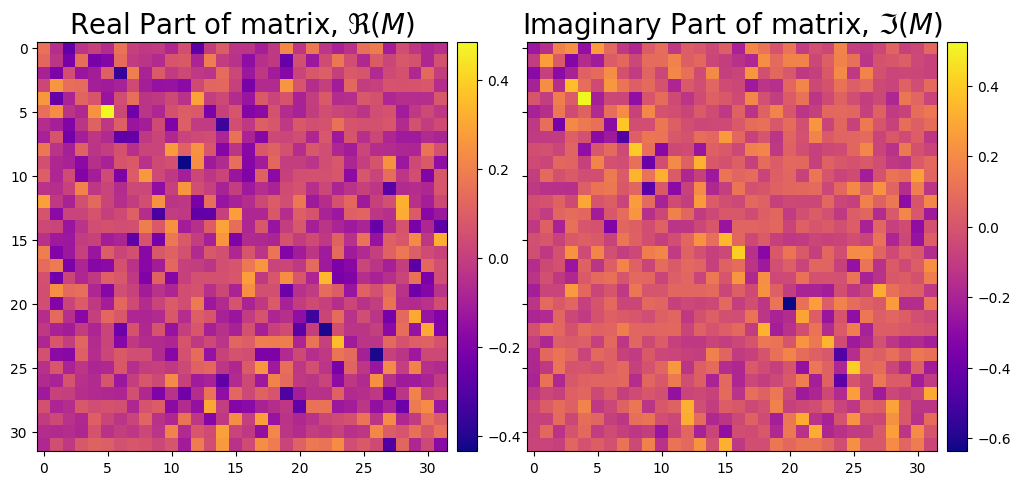

In [156]:
#Comparison of Hamiltonians at end of periodic WAHUHA sequence
#For T = 0.015, 0.24
heatmap2d(wahuha2(Hint,100,0.015)@pi2ymat)
heatmap2d(wahuha2(Hint,100,0.24)@pi2ymat)

Interesting stuff - the unitary operator on the initial spin up state seems to become fuzzier for a longer T.

Problem 2

Part a iii

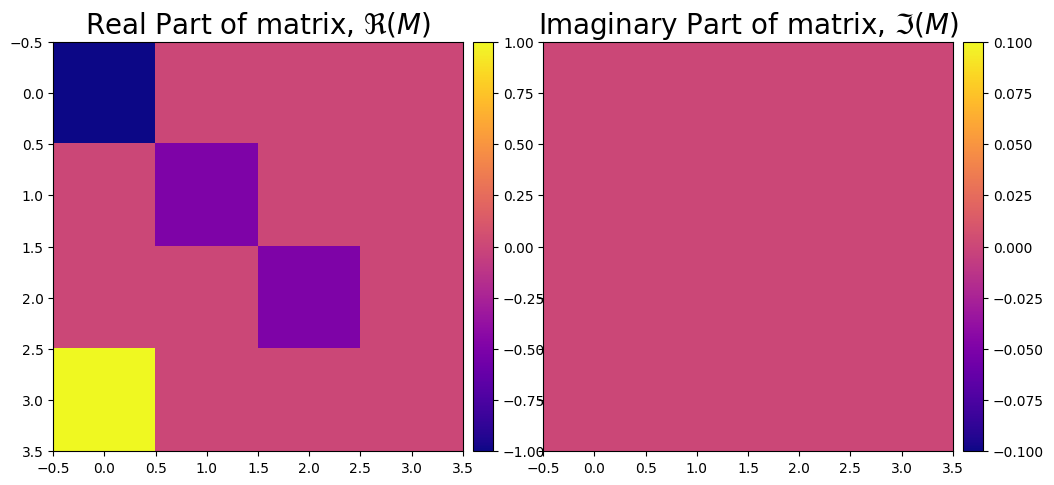

In [244]:
A = np.matrix([[0,0],[1,0]])
#With gamma prefactor, gamma = 1.
S = np.kron(A.H.T, A) - (1/2)*np.kron(((A.H)@A).T, I2) - (1/2)*np.kron(I2, (A.H)@A)
heatmap2d(S)

In [228]:
# Initial state |e><e|
rho0 = np.matrix([[1,0],[0,0]])
rho0 = np.squeeze(np.asarray(rho0.reshape(4,1)))
rho0

array([1, 0, 0, 0])

Text(0.5, 1.0, 'Master equation, H = 0, A = |g><e|, rho(0) = |e><e|')

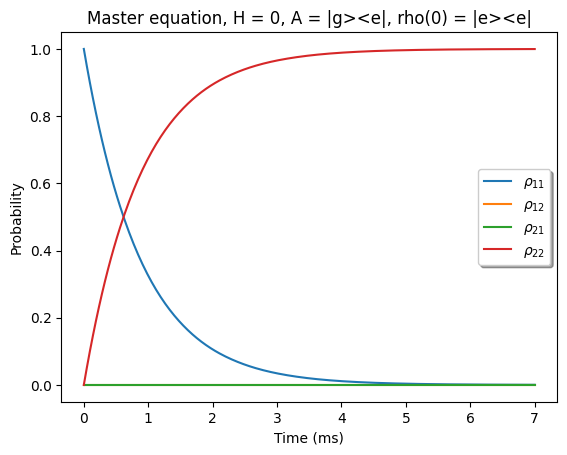

In [254]:
#Solve ODE with rho vector
def diffeq(t, rhovec, gamma):
    drhodt = gamma*(S@rhovec)
    return np.squeeze(np.asarray(drhodt))

#Set gamma=1.1234 to get T1 value from curve fit
gamma = 1.1234
tmax = 7
rho = scipy.integrate.solve_ivp(diffeq, t_span=[0,tmax], y0=rho0, args=(gamma,), dense_output=True)
time2 = np.linspace(0,tmax,300)

rhot = rho.sol(time2).T
plt.plot(time2, rhot)
plt.xlabel('Time (ms)')
plt.ylabel('Probability')
plt.legend([r"$\rho_{11}$", r"$\rho_{12}$", r"$\rho_{21}$", r"$\rho_{22}$"], shadow=True)
plt.title('Master equation, H = 0, A = |g><e|, rho(0) = |e><e|')

In [220]:
rhot

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.74042506e-01, 0.00000000e+00, 0.00000000e+00, 2.59574942e-02],
       [9.48758802e-01, 0.00000000e+00, 0.00000000e+00, 5.12411977e-02],
       ...,
       [4.08739471e-04, 0.00000000e+00, 0.00000000e+00, 9.99591261e-01],
       [3.98129620e-04, 0.00000000e+00, 0.00000000e+00, 9.99601870e-01],
       [3.87795174e-04, 0.00000000e+00, 0.00000000e+00, 9.99612205e-01]])

In [224]:
def f(t, a, b):
    return a * np.exp(-b * t)
params, _ = scipy.optimize.curve_fit(f, time2, rhot.T[0])
print(f'numerical value of 1/T1: {params[1]}')
print(f'Set value of gamma: {gamma}')

numerical value of 1/T1: 1.1233203207399585
Set value of gamma: 1.1234


From this we can clearly see that T1 = 1/gamma.

In [231]:
# Prepare and vectorize initial state |+x><+x|
x = (1/np.sqrt(2))*np.array([[1,1]])
rho0x = np.kron(x,x)
rho0x = np.squeeze(np.asarray(rho0x.reshape(4,1)))
rho0x

array([0.5, 0.5, 0.5, 0.5])

Text(0.5, 1.0, 'Master equation, H = 0, A = |g><e|, rho(0) = |+x><+x|')

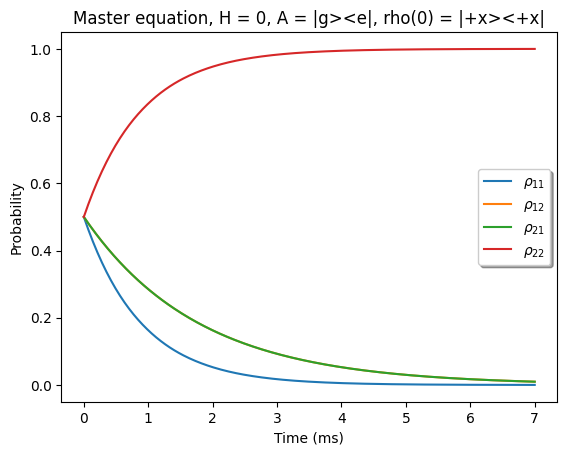

In [232]:
rhox = scipy.integrate.solve_ivp(diffeq, t_span=[0,tmax], y0=rho0x, args=(gamma,), dense_output=True)
rhoxt = rhox.sol(time2).T
plt.plot(time2, rhoxt)
plt.xlabel('Time (ms)')
plt.ylabel('Probability')
plt.legend([r"$\rho_{11}$", r"$\rho_{12}$", r"$\rho_{21}$", r"$\rho_{22}$"], shadow=True)
plt.title('Master equation, H = 0, A = |g><e|, rho(0) = |+x><+x|')

In [233]:
params, _ = scipy.optimize.curve_fit(f, time2, rhoxt.T[0])
print(f'numerical value of 1/T1 from rho11: {params[1]}')
print(f'Set value of gamma: {gamma}')

numerical value of 1/T1 from rho11: 1.1226746351708712
Set value of gamma: 1.1234


In [236]:
params, _ = scipy.optimize.curve_fit(f, time2, rhoxt.T[1])
print(f'numerical value of 1/T2 from rho21: {params[1]}')
print(f'Set value of gamma/2: {gamma/2}')

numerical value of 1/T2 from rho21: 0.5616912928906119
Set value of gamma/2: 0.5617


Thus we can clearly see that T1 = 1/gamma and T2 = 2/gamma.

Part B

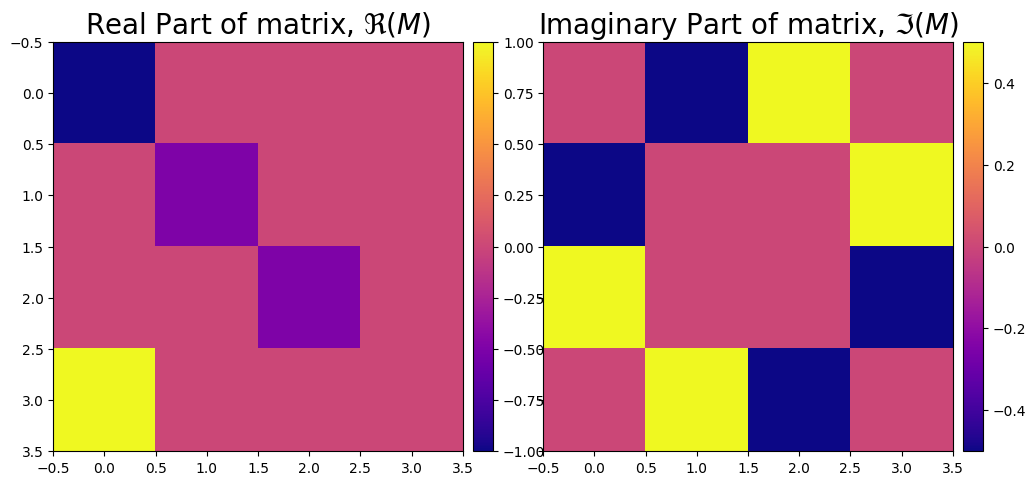

In [266]:
rho0g = np.kron([0,1],[0,1])
rho0g = np.array(np.squeeze(np.asarray(rho0g.reshape(4,1))), dtype=np.cdouble)

#Setting Omega = 1 to have units of omega/2pi in graphs
Hsx = np.matrix([[0,0.5],[0.5,0]])
#S in units of gamma
def S_(gamma):
    return (gamma*S + -1j*(np.kron(I2, Hsx) -np.kron(Hsx, I2)))

def diffeq2(t, rhovec, gamma):
    drhodt = (S_(gamma)@rhovec)
    return np.squeeze(np.asarray(drhodt))

heatmap2d(S_(1))

In [296]:

tmax = 100
time2 = np.linspace(0,tmax,300)

def plotrho(g):
    rhog = scipy.integrate.solve_ivp(diffeq2, t_span=[0,tmax], y0=rho0g, args=(g,), dense_output=True)
    rhogt = rhog.sol(time2).T
    theoreticalDecay = (1/2)+f(time2, 0.5, 0.75*g)
    plt.plot(time2/(2*pi), rhogt)
    plt.plot(time2/(2*pi), theoreticalDecay)
    plt.xlabel('Time (omega/2pi)')
    plt.ylabel('Probability')
    plt.legend([r"$\rho_{11}$", r"$\rho_{12}$", r"$\rho_{21}$", r"$\rho_{22}$", 'Predicted decay'], shadow=True)
    plt.title(f'Master equation, H = Sx, A = |g><e|, rho(0) = |+g><+g|, gamma = {g}')
    plt.grid(visible=True, which='both')

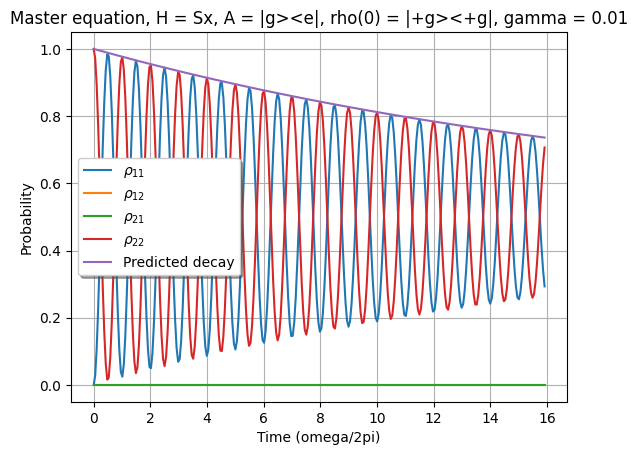

In [293]:
#Plotting rho(t) for gamma=0.01 (omega=1 for correct scaling).
#Theoretical decay plotted from the analytical formula in b i
plotrho(0.01)

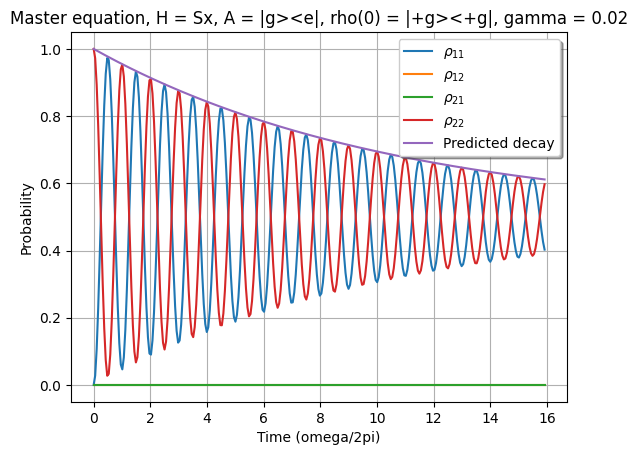

In [279]:
#gamma = 0.02
plotrho(0.02)

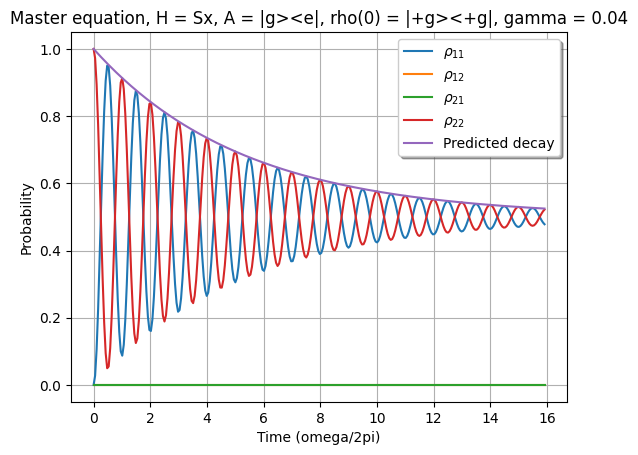

In [283]:
#gamma = 0.04
plotrho(0.04)

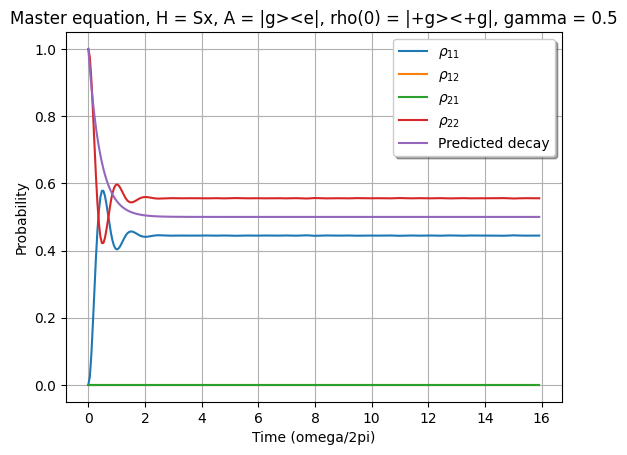

In [287]:
#Observing breakdown of the approximation, gamma = 0.4, omega = 1
plotrho(0.5)

Note that Pg(t) is simply rho22. It is evident that in the case of gamma<<omega, we have that the numerical simulation matches the analytical expression. From the gridlines, we can see the frequency of oscillation is 1 in units of omega/2pi, which matches the analytical expression. Furthermore, the theoretical exponential decay (1/T1 = 3/4 gamma) fits the numerical decay perfectly. We can also observe our approximation breaking down for large values of gamma.

b, iii

From our superoperator, we see that this represents a depolarization channel with a decay time of gamma/4. We also maintain the nonunitary Linbladian operator from the previous part, which we showed has a decay time for dephasing of gamma/2. Together this makes 3gamma/4.